In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 22452.47it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

# dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)


In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

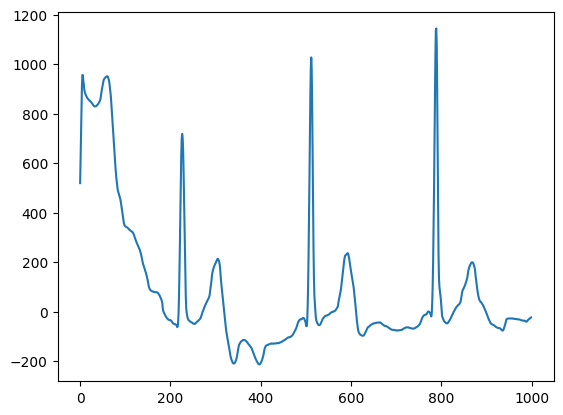

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:0.02477 AVG Test Loss:0.02315 AVG Training Acc 53.45 % AVG Test Acc 58.14 %
Epoch:20/200 AVG Training Loss:0.02303 AVG Test Loss:0.02193 AVG Training Acc 59.40 % AVG Test Acc 63.54 %
Epoch:30/200 AVG Training Loss:0.02218 AVG Test Loss:0.02106 AVG Training Acc 61.41 % AVG Test Acc 65.33 %
Epoch:40/200 AVG Training Loss:0.02127 AVG Test Loss:0.02120 AVG Training Acc 62.65 % AVG Test Acc 67.13 %
Epoch:50/200 AVG Training Loss:0.02099 AVG Test Loss:0.02146 AVG Training Acc 62.96 % AVG Test Acc 68.41 %
Epoch:60/200 AVG Training Loss:0.02052 AVG Test Loss:0.01932 AVG Training Acc 64.27 % AVG Test Acc 67.46 %
Epoch:70/200 AVG Training Loss:0.02000 AVG Test Loss:0.01979 AVG Training Acc 65.76 % AVG Test Acc 69.24 %
Epoch:80/200 AVG Training Loss:0.02003 AVG Test Loss:0.01923 AVG Training Acc 66.04 % AVG Test Acc 69.91 %
Epoch:90/200 AVG Training Loss:0.01962 AVG Test Loss:0.01846 AVG Training Acc 65.76 % AVG Test Acc 70.76 %
Epoch:100/200 AVG Training Loss:0.019

In [13]:
len(dataset_12lead)/20

165.9

Fold 1
Epoch:10/100 AVG Training Loss:0.01108 AVG Test Loss:0.00646 AVG Training Acc 64.24 % AVG Test Acc 65.49 %
Epoch:20/100 AVG Training Loss:0.00983 AVG Test Loss:0.00565 AVG Training Acc 70.30 % AVG Test Acc 67.36 %
Epoch:30/100 AVG Training Loss:0.00748 AVG Test Loss:0.00543 AVG Training Acc 78.79 % AVG Test Acc 68.79 %
Epoch:40/100 AVG Training Loss:0.00752 AVG Test Loss:0.00525 AVG Training Acc 80.00 % AVG Test Acc 70.57 %
Epoch:50/100 AVG Training Loss:0.00654 AVG Test Loss:0.00501 AVG Training Acc 88.48 % AVG Test Acc 72.69 %
Epoch:60/100 AVG Training Loss:0.00533 AVG Test Loss:0.00527 AVG Training Acc 92.12 % AVG Test Acc 71.74 %
Early stopping triggered after epoch 69
Fold 2
Epoch:10/100 AVG Training Loss:0.01189 AVG Test Loss:0.00714 AVG Training Acc 67.27 % AVG Test Acc 65.21 %
Epoch:20/100 AVG Training Loss:0.01102 AVG Test Loss:0.00600 AVG Training Acc 73.33 % AVG Test Acc 68.70 %
Epoch:30/100 AVG Training Loss:0.00777 AVG Test Loss:0.00556 AVG Training Acc 84.24 % AVG 

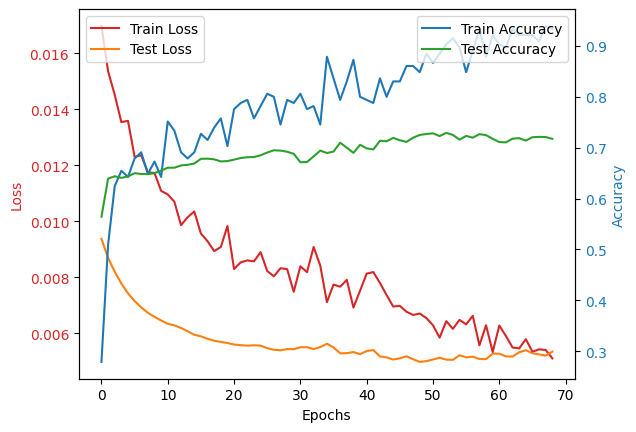

Overall results of 20 fold cross-validation with leave-19-out
Train: Average loss 0.005937590117043672, average accuracy 92.61628331507852
Test: Average loss 0.005714900643091586, average accuracy 71.04311108508374


In [14]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=20
trainparams.m=19
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, buffer, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1


Epoch:10/200 AVG Training Loss:0.01416 AVG Test Loss:0.00911 AVG Training Acc 40.61 % AVG Test Acc 37.84 %
Epoch:20/200 AVG Training Loss:0.01307 AVG Test Loss:0.00877 AVG Training Acc 40.61 % AVG Test Acc 40.28 %
Epoch:30/200 AVG Training Loss:0.01235 AVG Test Loss:0.00834 AVG Training Acc 48.48 % AVG Test Acc 47.89 %
Epoch:40/200 AVG Training Loss:0.00960 AVG Test Loss:0.00793 AVG Training Acc 65.45 % AVG Test Acc 50.94 %
Epoch:50/200 AVG Training Loss:0.00727 AVG Test Loss:0.00831 AVG Training Acc 78.79 % AVG Test Acc 53.12 %
Early stopping triggered after epoch 59
Fold 2
Epoch:10/200 AVG Training Loss:0.01437 AVG Test Loss:0.00929 AVG Training Acc 38.18 % AVG Test Acc 33.30 %
Epoch:20/200 AVG Training Loss:0.01319 AVG Test Loss:0.00887 AVG Training Acc 40.00 % AVG Test Acc 42.97 %
Epoch:30/200 AVG Training Loss:0.01202 AVG Test Loss:0.00875 AVG Training Acc 51.52 % AVG Test Acc 43.96 %
Epoch:40/200 AVG Training Loss:0.00907 AVG Test Loss:0.00849 AVG Training Acc 72.12 % AVG Test Ac

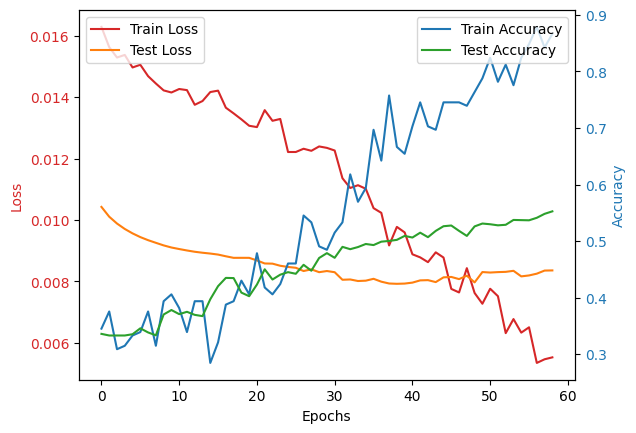

Overall results of 20 fold cross-validation with leave-19-out
Train: Average loss 0.005816046045334856, average accuracy 87.9726177437021
Test: Average loss 0.008111099048425182, average accuracy 56.27528059249026


In [15]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=20
trainparams.m=19
trainparams.early_stopping=20

history = train_control_12lead_model(dataset_12lead, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [16]:
transfer_def = TransferDef()
transfer_def.return_request = [4]

from torch.utils.tensorboard import SummaryWriter

model = TransferModel(buffer, transfer_def)

# Initialize the summary writer
writer = SummaryWriter()

# Create dummy input that corresponds to the network's input shape
input_tensor = torch.rand(128, 1000, 12)

# Add the model graph to TensorBoard
writer.add_graph(model, input_tensor)
writer.close()


# test_forwards(model, data_12lead, labelmap, device)

/home/mattyab/.local/lib/python3.10/site-packages/torch/jit/_trace.py:1065: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(
